# Neural Style Transfer

Neural Style Transfer is an optimization technique used to take 2 images - a *content* image and a *style reference* image and blend them together so the output image look slike the content image, but "painted" in the style of the reference image.

NST employs a pretrained convolution Neural Network to transfer "styles" from a given image to another. This is done by defining a loss function that tries to minimize the activation difference between the content image, style image and the combined generated image.

For instance consider the following images:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt="Drawing" style="width: 200px;"/>
<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt="Drawing" style="width: 200px;"/>

After applying NST, we'd get something like the following image:


<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>

In [ ]:
# downloading the required images and storing them in a directory
import os
img_dir = '/tmp/nst'
if not os.path.exists(img_dir):
  os.makedirs(img_dir)

!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /tmp/nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [ ]:
# importing essential libraries
import matplotlib.pyplot as plt
import matplotlib as mp
mp.rcParams['figure.figsize'] = (10, 10)
mp.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools

In [ ]:
# importing tensorflow 
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
# we are using eager execution (from tensorflow)
tf.enable_eager_execution()
print("Eager Execution: {}".format(tf.executing_eagerly()))

Eager Execution: True


In [ ]:
# set content and style image
content_path = '/tmp/nst/Tuebingen_Neckarfront.jpg'
style_path = '/tmp/nst/The_Great_Wave_off_Kanagawa.jpg'

# Image Visualization

In [ ]:
# utility function to load image
def img_load(path):
  max_d=512
  img = Image.open(path)
  long = max(img.size)
  scale = max_d/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img = kp_image.img_to_array(img)

  img = np.expand_dims(img, axis=0)
  return img


In [ ]:
# utility function to view the image
def imshow(img, title=None):
  output = np.squeeze(img, axis=0)
  output = output.astype('uint8')
  plt.imshow(output)
  if title is not None:
    plt.title(title)
  plt.imshow(output)

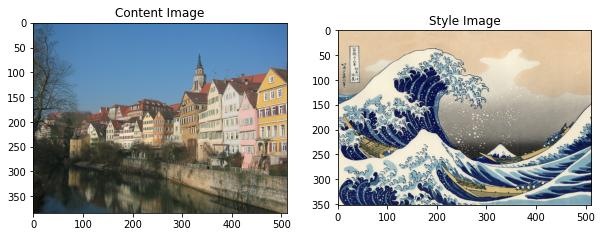

In [ ]:
# plotting the image
plt.figure(figsize=(10,10))

content = img_load(content_path).astype('uint8')
style = img_load(style_path).astype('uint8')

plt.subplot(1,2,1)
imshow(content, 'Content Image')

plt.subplot(1,2,2)
imshow(style, 'Style Image')
plt.show()

# Data Preprocessing


In [ ]:
# utility function to perform image loading and processing
# preprocessing is done according to the VGG training process

def load_and_process(path):
  # load the image
  img = img_load(path)
  # pass the loaded image for preprocessing
  #img = tf.keras.applications.vgg19.preprocess_input(img)
  img = tf.keras.applications.vgg16.preprocess_input(img)
  return img

In [ ]:
# deprocess image. This is done to view the outputs of the optimization. 
def deprocess(processed_img):
  temp = processed_img.copy()
  if len(temp.shape) == 4:
    temp = np.squeeze(temp, 0)
  assert len(temp.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(temp.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  temp[:, :, 0] += 103.939
  temp[:, :, 1] += 116.779
  temp[:, :, 2] += 123.68
  temp = temp[:, :, ::-1]

  temp = np.clip(temp, 0, 255).astype('uint8')
  return temp

# Defining content and style Layers

To get both the content and the style representations, we'll look at intermediate layers of the VGG19 model. As we go deeper into the model these intermediate layers represent higher and higher order features. We'll be using VGG19 network architecture.

In [ ]:
# content layers
content_layers = ['block5_conv2']

# style layers
style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',
]

content_layers_len = len(content_layers)
style_layers_len = len(style_layers)

# Building the model

We will now load the VGG19 and feed out input to the model. This will help us extract the feature maps of content, style and generated image.

In [ ]:
# get_model loads the pretrained network and the grab the layers of interest. 
# model takes in an input image and output the content and style intermediate layers
def get_model():
  # load model. (Pretrained vgg on imagenet)
  # vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')
  vgg.trainable = False
  # output layers corresponding to style and content layers
  content_output = [vgg.get_layer(content).output for content in content_layers]
  style_output = [vgg.get_layer(style).output for style in style_layers]
  model_output = style_output + content_output
  
  model = models.Model(vgg.input, model_output)
  return model

# Content Loss


In [ ]:
# get_content_loss returns the content loss
def get_content_loss(base, target):
  return tf.reduce_mean(tf.square(base-target))

# Style Loss


In [ ]:
def gram_matrix(input_tensor):
  # image channels
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

# Apply style transfer to our images

## Gradient Descent

We'll use the Adam optimizer in order to minimize our loss. We iteratively update our output image such that it minimizes our loss:

In [ ]:
# utility function to compute content and style feature representations.
def get_feature_rep(model, content, style):
  # This function loads and preprocesses both the content and style images
  # from their path. Then it feeds them through the network get the feature maps

  # load images
  content_img = load_and_process(content)
  style_img = load_and_process(style)

  # batch compute content and style features
  content_output = model(content_img)
  style_output = model(style_img)

  # get feature representations
  content_feat = [content_layer[0] for content_layer in content_output[style_layers_len:]]
  style_feat = [style_layer[0] for style_layer in style_output[:style_layers_len]]
  
  return style_feat, content_feat

# Computing loss and gradient

We'll now use tf.GradientTape to compute the gradient. 

In [ ]:
# function to compute total loss.
def compute_loss(model, loss_wt, iimg, gram_style_feat, content_feat):
  style_wt, content_wt = loss_wt
  # feed the image through the model. This will give the content and style representations
  model_output = model(iimg)

  style_out_feat = model_output[:style_layers_len]
  content_out_feat = model_output[style_layers_len:]

  style_score = 0
  content_score = 0

  # accumulate style loss
  wt_per_style_layer = 1.0/float(style_layers_len)
  for target_style, comb_style in zip(gram_style_feat, style_out_feat):
    style_score += wt_per_style_layer * get_style_loss(comb_style[0], target_style)
  
  # accumulate content losses
  wt_per_content_layer = 1.0/float(content_layers_len)
  for target_content, comb_content in zip(content_feat, content_out_feat):
    content_score += wt_per_content_layer * get_content_loss(comb_content[0], target_content)

  style_score *= style_wt
  content_score *= content_wt

  # total loss
  loss = style_score + content_score
  return loss, style_score, content_score


In [ ]:
# Computing the gradient
def compute_gradient(cfg):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['iimg']), all_loss

# Optimization Loop

In [ ]:
import IPython.display

def style_transfer(cont_path, style_path, itr=1000, cont_wt=1e3, style_wt=1e-2):
  model = get_model()
  # no need to train to model
  for layer in model.layers:
    layer.trainable = False
  # Get the style and content features
  style_feats, cont_feats = get_feature_rep(model, cont_path, style_path)
  gram_style_feat = [gram_matrix(style_feat) for style_feat in style_feats]

  # initial image
  init_image = load_and_process(cont_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  # Optimizer: We are using Adam Optimizer
  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  # for displaying intermediate images
  itr_count = 1

  # store result with best score
  best_loss, best_img = float('inf'), None

  loss_wt = (style_wt, cont_wt)
  config = {
      'model': model,
      'loss_wt': loss_wt,
      'iimg': init_image,
      'gram_style_feat': gram_style_feat,
      'content_feat': cont_feats
  }

  # displaying
  num_rows = 2
  num_cols = 5

  display_interval = itr/(num_rows*num_cols)
  start_t = time.time()
  global_start = time.time()

  norm_means = np.array([103.939, 116.779, 123.68])
  min_val = -norm_means
  max_val = 255-norm_means

  imgs = []
  for i in range(itr):
    grads, all_loss = compute_gradient(config)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_val, max_val)
    init_image.assign(clipped)
    end_t = time.time()

    if loss < best_loss:
      best_loss = loss
      best_img = deprocess(init_image.numpy())

      if i%display_interval==0:
        start_t = time.time()
        plot_img = init_image.numpy()
     #   print(init_image)
        plot_img = deprocess(plot_img)
     #   print(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))
        print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_t))
  print('Total time: {:.4f}s'.format(time.time()-global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i, img in enumerate(imgs):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

  return best_img, best_loss

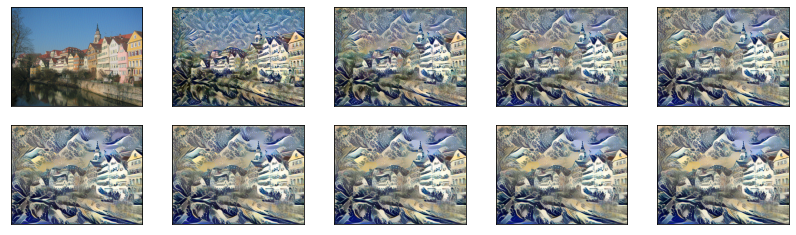

In [ ]:
best, best_loss = style_transfer(content_path, style_path, itr=1000)

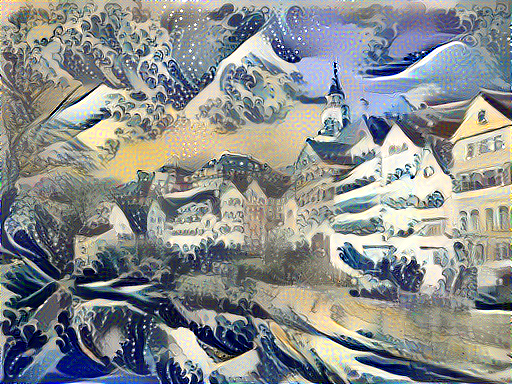

In [ ]:
Image.fromarray(best)

# Testing on other inputs

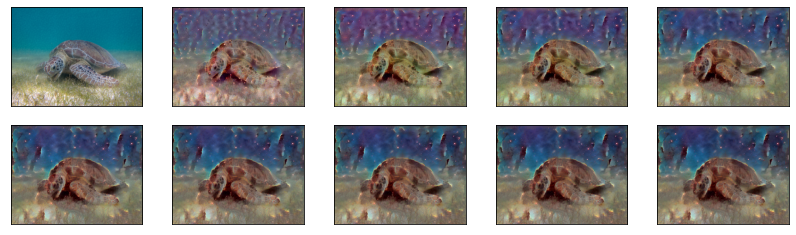

In [ ]:
best_pic, best_loss = style_transfer('/tmp/nst/Green_Sea_Turtle_grazing_seagrass.jpg', '/tmp/nst/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg')

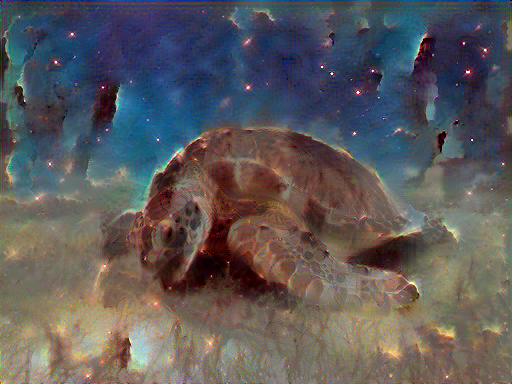

In [ ]:
Image.fromarray(best_pic)

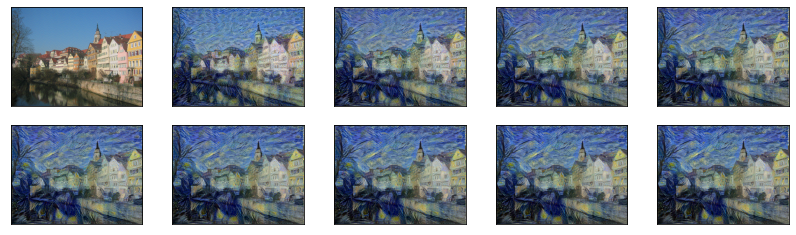

In [ ]:
best_pic, best_loss = style_transfer('/tmp/nst/Tuebingen_Neckarfront.jpg',
             '/tmp/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')

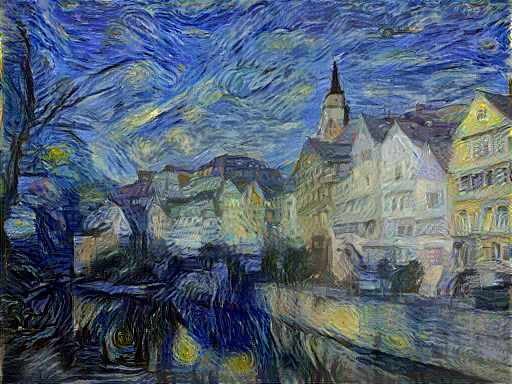

In [ ]:
Image.fromarray(best_pic)